In [1]:
!pip install dionysus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Created wheel for dionysus: filename=dionysus-2.0.8-cp38-cp38-linux_x86_64.whl size=319864 sha256=d3cf2b0743a2d2464b94795f94e1114015eb89c9ca557c121f8a32169256b51e
  Stored in directory: /root/.cache/pip/wheels/0e/6a/ce/a54c9248873852edfaf8e6e801db84c2d2c64f797fc07a68da
Successfully built dionysus


In [2]:
from __future__ import print_function   # if you are using Python 2

import dionysus as d
import numpy as np
import matplotlib as plt

from numpy.random import seed
from numpy.random import rand
import matplotlib.pyplot as plt
import math
import time

In [3]:
def get_verts(simp):
    if simp.dimension == 2:
        return [d.Simplex([v], 0) for v in t]
    else:
        return set([s for s in simp.boundary()])

def fix_dio_vert_nums(Cplx, vertind):
    New_Cplx = []
    for s in Cplx:
        # s.data = data
        vlist = []
        for v in s:
            vlist.append(v+vertind)
        s = d.Simplex(vlist, s.data)

        New_Cplx.append(s)
    return New_Cplx

In [20]:
def setup_Zigzag_fixed_test(lst, verbose=False):
    # lst = list(self.ptclouds['PtCloud'])

    # simps_df = pd.DataFrame(columns = ['Simp','B,D'])
    simps_list = []
    times_list = []

    # Vertex counter
    vertind = 0

    init_st = time.time()
    # Initialize A with R(X_0)
    rips = d.fill_freudenthal(lst[0], reverse = False)
    rips.sort()
    rips_set = set(rips)
    
    for i in rips:
        print (i)


    # Initialize A with set of simplices with verts in X_0
    A = rips_set

    # # Add all simps to the list with birth,death=[0,1]
    simps_list = simps_list + [s for s in A]
    print ('simp_lilst with only A: {}'.format(simps_list))
    times_list = times_list + [[0, 1] for j in range(len(A))]

    # Initialize with vertices for X_0
    verts = set([d.Simplex([j+vertind], 0)
                    for j, pc in enumerate(lst[0])])

    init_end = time.time()
    if verbose:
        print(f'Initializing done in {init_end-init_st} seconds...')

    loop_st = time.time()
    # Loop over the rest of the point clouds
    for i in range(1, len(lst)):

        # Calculate rips of X_{i-1} \cup X_i
        rips = d.fill_freudenthal(np.vstack([lst[i-1], lst[i]]), reverse = False)

        # Adjust vertex numbers, sort, and make into a set
        rips = fix_dio_vert_nums(rips, vertind)
        rips.sort()
        rips_set = set(rips)

        # Increment vertex counter
        vertind = vertind+len(verts)

        # Set of vertices in R(X_i)
        verts_next = set([d.Simplex([j+vertind], 0)
                            for j, pc in enumerate(lst[i])])

        # Set of simplices with verts in X_{i}
        B = d.fill_freudenthal(lst[i], reverse = False)
        #B = shift_filtration(B, i * len(A))

        # Set of simplices with verts in X_{i-1} AND X_{i}
        M = set()

        # Loop over vertices in R(X_{i-1} \cup R_i)
        for simp in rips:
            
            # Get list of vertices of simp
            bdy = get_verts(simp)

            # If it has no boundary and its in B, its a vertex in B and has been handled
            if not bdy:
                continue

            # If all of its verts are in A, it's been handled in the initialization or the previous iteration
            if bdy.intersection(A) == bdy:
                continue

            # If all of its verts are in B, add it to B
            elif bdy.intersection(B) == bdy:
                B.add(simp)

            # If it has some verts in A and some in B, it only exists in the union
            # Add it to M
            else:
                M.add(simp)

        # Add simplices in B with the corresponding birth,death times
        simps_list = simps_list + [s for s in B]
        print ('simp_lilst with only A, B: {}'.format(simps_list))
        times_list = times_list + [[i-0.5, i+1] for j in range(len(B))]

        # Add simplicies in M with corresponding birth,death times
        simps_list = simps_list + [s for s in M]
        print ('simp_lilst with only A, B, M: {}'.format(simps_list))
        times_list = times_list + [[i-0.5, i] for j in range(len(M))]

        #print ('length of filtration in iter {}: {}'.format(i, len(simps_list)))
        #print ('length of time list in iter {}: {}'.format(i, len(times_list)))
        # Reinitialize for next iteration
        verts = verts_next
        A = B

    print (simps_list)
    print ('length of filtration: {}'.format(len(simps_list)))
    print ('length of time list: {}'.format(len(times_list)))
    loop_end = time.time()
    if verbose:
        print(f'Preprocessing done in {loop_end-loop_st} seconds...')

    f_st = time.time()
    filtration = d.Filtration(simps_list)
    f_end = time.time()

    return filtration, times_list

In [5]:
def setup_Zigzag_fixed(lst, verbose=False):
    # lst = list(self.ptclouds['PtCloud'])

    # simps_df = pd.DataFrame(columns = ['Simp','B,D'])
    simps_list = []
    times_list = []

    # Vertex counter
    vertind = 0

    init_st = time.time()
    # Initialize A with R(X_0)
    rips = d.fill_freudenthal(lst[0], reverse = False)
    rips.sort()
    rips_set = set(rips)

    # Initialize A with set of simplices with verts in X_0
    A = rips_set

    # # Add all simps to the list with birth,death=[0,1]
    simps_list = simps_list + [s for s in A]
    times_list = times_list + [[0, 1] for j in range(len(A))]

    # Initialize with vertices for X_0
    verts = set([d.Simplex([j+vertind], 0)
                    for j, pc in enumerate(lst[0])])

    init_end = time.time()
    if verbose:
        print(f'Initializing done in {init_end-init_st} seconds...')

    loop_st = time.time()
    # Loop over the rest of the point clouds
    for i in range(1, len(lst)):

        # Calculate rips of X_{i-1} \cup X_i
        rips = d.fill_freudenthal(np.vstack([lst[i-1], lst[i]]), reverse = False)

        # Adjust vertex numbers, sort, and make into a set
        rips = fix_dio_vert_nums(rips, vertind)
        rips.sort()
        rips_set = set(rips)

        # Increment vertex counter
        vertind = vertind+len(verts)

        # Set of vertices in R(X_i)
        verts_next = set([d.Simplex([j+vertind], 0)
                            for j, pc in enumerate(lst[i])])

        # Set of simplices with verts in X_{i}
        B = set(verts_next.intersection(rips_set))

        # Set of simplices with verts in X_{i-1} AND X_{i}
        M = set()

        # Loop over vertices in R(X_{i-1} \cup R_i)
        for simp in rips:

            # Get list of vertices of simp
            bdy = get_verts(simp)

            # If it has no boundary and its in B, its a vertex in B and has been handled
            if not bdy:
                continue

            # If all of its verts are in A, it's been handled in the initialization or the previous iteration
            if bdy.intersection(A) == bdy:
                continue

            # If all of its verts are in B, add it to B
            elif bdy.intersection(B) == bdy:
                B.add(simp)

            # If it has some verts in A and some in B, it only exists in the union
            # Add it to M
            else:
                M.add(simp)

        # Add simplices in B with the corresponding birth,death times
        simps_list = simps_list + [s for s in B]
        times_list = times_list + [[i-0.5, i+1] for j in range(len(B))]

        # Add simplicies in M with corresponding birth,death times
        simps_list = simps_list + [s for s in M]
        times_list = times_list + [[i-0.5, i] for j in range(len(M))]

        print ('length of filtration in iter {}: {}'.format(i, len(simps_list)))
        print ('length of time list in iter {}: {}'.format(i, len(times_list)))
        # Reinitialize for next iteration
        verts = verts_next
        A = B

    print (simps_list)
    print ('length of filtration: {}'.format(len(simps_list)))
    print ('length of time list: {}'.format(len(times_list)))
    loop_end = time.time()
    if verbose:
        print(f'Preprocessing done in {loop_end-loop_st} seconds...')

    f_st = time.time()
    filtration = d.Filtration(simps_list)
    f_end = time.time()

    return filtration, times_list

In [6]:
def shift_filtration(rips,n):
    "Take a Dionysus filtration and increase the name of all of the vertices by n."
    f = d.Filtration()
    for s in rips:
        dim = s.dimension()
        temp = []
        for i in range(0,dim+1):
            temp.append(s[i]+n)
        f.append(d.Simplex(temp,s.data))
    return f

def complex_union(f,g):
    "Takes two filtrations and builds their union simplicial complex."
    union = d.Filtration()
    for s in f:
        union.append(s)
    for s in g:
        union.append(s)
    return union

def build_zigzag_times(rips,n,numbins):
    """ rips should be a union of angle bins as a Dionysus simplicial complex.
      n is the number of data points in each bin.
      numbins is the number of bins of data points, EXCLUDING unions.
      Returns times - the zig-zag birth and death times (list of lists length n)."""
    times = [[] for x in range(0,rips.__len__())]
    i=0
    for x in rips:
       dim = x.dimension()
       t = [];
       for k in range(0,dim+1):
          t.append(x[k])
       xmin = math.floor(min(t)/n)
       xmax = math.floor(max(t)/n)
       if xmax == 0:
          bd = [0,1]
       elif xmin == numbins-1:
          bd = [2*xmin-1,2*xmin]
       elif xmax == xmin:
          bd = [2*xmin-1,2*xmin+1]
       elif xmax > xmin:
          bd = [2*xmax-1,2*xmax-1]
       else:
          print("Something has gone horribly wrong!")
       times[i] = bd
       i = i+1
    return times

def compute_zigzag(f,times):
    zz, dgms, cells = d.zigzag_homology_persistence(f, times)
    return dgms

## Trivial 1d example with a sequence of simplicial complexes

See https://mrzv.org/software/dionysus2/tutorial/basics.html#filtration for details

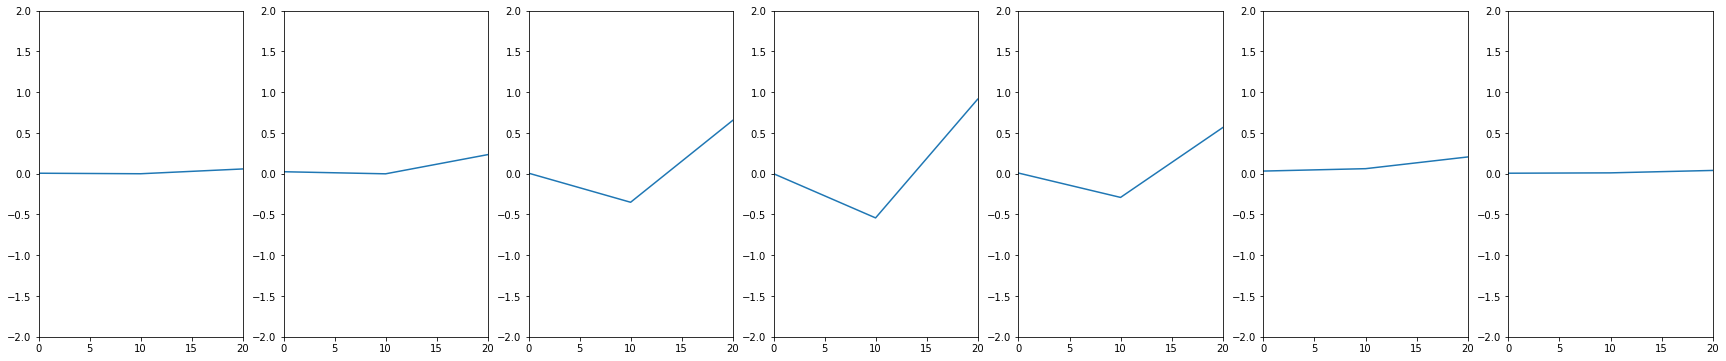

In [29]:
seed(0)
values = rand(3) - 0.5


x = np.linspace(0, 20, 3)
y1 = 0.05 * np.sin(x) + (1/8) * values
y2 = 0.2 * np.sin(x) + (1/2) * values
y3 = 0.7 * np.sin(x) + (1/7) * values
y4 = 1.0 * np.sin(x) + 0.01 * values
y5 = 0.6 * np.sin(x) + (1/6) * values
y6 = 0.15 * np.sin(x) + (1/1.5) * values
y7 = 0.03 * np.sin(x) + (1/8) * values
y = np.array([*y1, *y2, *y3, *y4, *y5, *y6, *y7])

fig = plt.figure(figsize=(30, 6))

ax1 = fig.add_subplot(171)
ax1.set_xlim([0, 20])
ax1.set_ylim([-2, 2])
ax1.plot(x, y1)

ax2 = fig.add_subplot(172)
ax2.set_xlim([0, 20])
ax2.set_ylim([-2, 2])
ax2.plot(x, y2)

ax3 = fig.add_subplot(173)
ax3.set_xlim([0, 20])
ax3.set_ylim([-2, 2])
ax3.plot(x, y3)

ax4 = fig.add_subplot(174)
ax4.set_xlim([0, 20])
ax4.set_ylim([-2, 2])
ax4.plot(x, y4)

ax5 = fig.add_subplot(175)
ax5.set_xlim([0, 20])
ax5.set_ylim([-2, 2])
ax5.plot(x, y5)

ax6 = fig.add_subplot(176)
ax6.set_xlim([0, 20])
ax6.set_ylim([-2, 2])
ax6.plot(x, y6)

ax7 = fig.add_subplot(177)
ax7.set_xlim([0, 20])
ax7.set_ylim([-2, 2])
ax7.plot(x, y7)

plt.show()

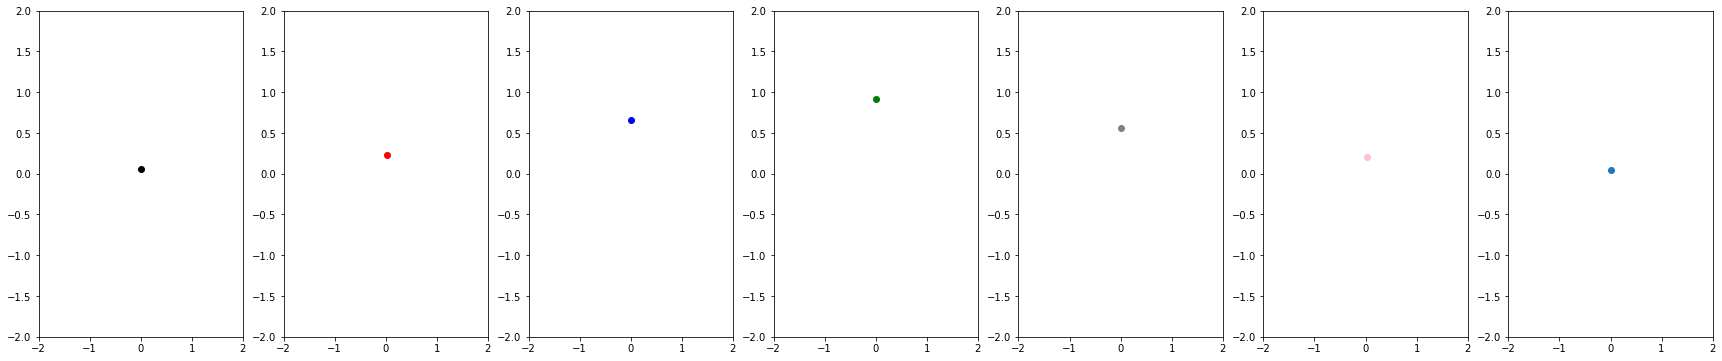

In [30]:
tau = 2

fig2 = plt.figure(figsize=(30, 6))
ax21 = fig2.add_subplot(171)
ax21.set_xlim([-2, 2])
ax21.set_ylim([-2, 2])
ax21.scatter(y1[0:-tau], y1[tau:], color = 'black')

ax22 = fig2.add_subplot(172)
ax22.set_xlim([-2, 2])
ax22.set_ylim([-2, 2])
ax22.scatter(y2[0:-tau], y2[tau:], color = 'r')

ax23 = fig2.add_subplot(173)
ax23.set_xlim([-2, 2])
ax23.set_ylim([-2, 2])
ax23.scatter(y3[0:-tau], y3[tau:], color = 'b')

ax24 = fig2.add_subplot(174)
ax24.set_xlim([-2, 2])
ax24.set_ylim([-2, 2])
ax24.scatter(y4[0:-tau], y4[tau:], color = 'green')

ax25 = fig2.add_subplot(175)
ax25.set_xlim([-2, 2])
ax25.set_ylim([-2, 2])
ax25.scatter(y5[0:-tau], y5[tau:], color = 'grey')

ax26 = fig2.add_subplot(176)
ax26.set_xlim([-2, 2])
ax26.set_ylim([-2, 2])
ax26.scatter(y6[0:-tau], y6[tau:], color = 'pink')

ax27 = fig2.add_subplot(177)
ax27.set_xlim([-2, 2])
ax27.set_ylim([-2, 2])
ax27.scatter(y7[0:-tau], y7[tau:])

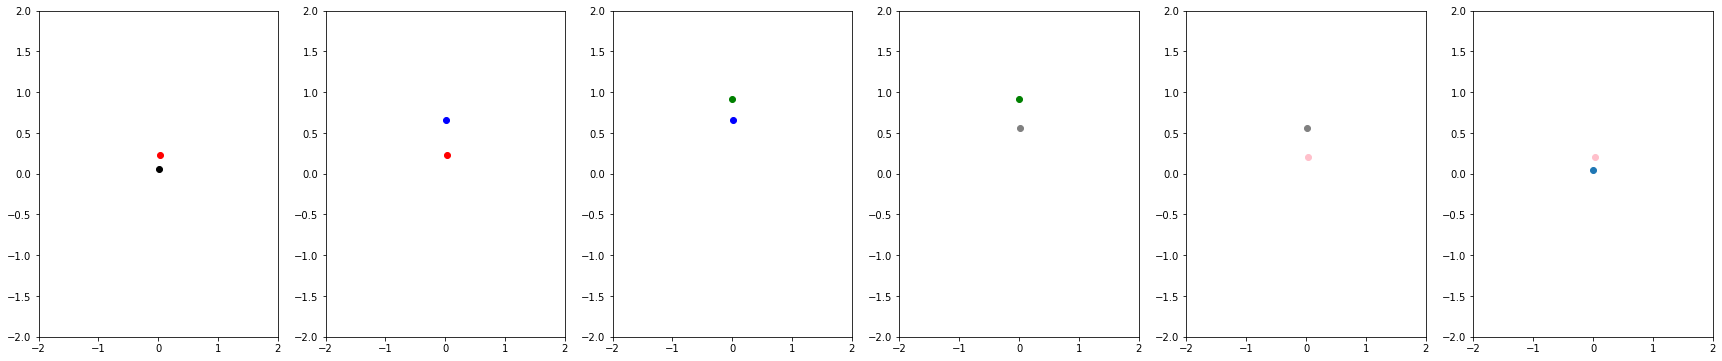

In [31]:
fig3 = plt.figure(figsize=(30, 6))
ax31 = fig3.add_subplot(161)
ax31.set_xlim([-2, 2])
ax31.set_ylim([-2, 2])
ax31.scatter(y1[0:-tau], y1[tau:], color = 'black')
ax31.scatter(y2[0:-tau], y2[tau:], color = 'r')

ax32 = fig3.add_subplot(162)
ax32.set_xlim([-2, 2])
ax32.set_ylim([-2, 2])
ax32.scatter(y2[0:-tau], y2[tau:], color = 'r')
ax32.scatter(y3[0:-tau], y3[tau:], color = 'b')

ax33 = fig3.add_subplot(163)
ax33.set_xlim([-2, 2])
ax33.set_ylim([-2, 2])
ax33.scatter(y3[0:-tau], y3[tau:], color = 'b')
ax33.scatter(y4[0:-tau], y4[tau:], color = 'green')

ax34 = fig3.add_subplot(164)
ax34.set_xlim([-2, 2])
ax34.set_ylim([-2, 2])
ax34.scatter(y4[0:-tau], y4[tau:], color = 'green')
ax34.scatter(y5[0:-tau], y5[tau:], color = 'grey')

ax35 = fig3.add_subplot(165)
ax35.set_xlim([-2, 2])
ax35.set_ylim([-2, 2])
ax35.scatter(y5[0:-tau], y5[tau:], color = 'grey')
ax35.scatter(y6[0:-tau], y6[tau:], color = 'pink')

ax36 = fig3.add_subplot(166)
ax36.set_xlim([-2, 2])
ax36.set_ylim([-2, 2])
ax36.scatter(y6[0:-tau], y6[tau:], color = 'pink')
ax36.scatter(y7[0:-tau], y7[tau:])

In [32]:
dataset1 = np.transpose(np.array([y1[0:-tau], y1[tau:]]))
dataset2 = np.transpose(np.array([y2[0:-tau], y2[tau:]]))
dataset3 = np.transpose(np.array([y3[0:-tau], y3[tau:]]))
dataset4 = np.transpose(np.array([y4[0:-tau], y4[tau:]]))
dataset5 = np.transpose(np.array([y5[0:-tau], y5[tau:]]))
dataset6 = np.transpose(np.array([y6[0:-tau], y6[tau:]]))
dataset7 = np.transpose(np.array([y7[0:-tau], y7[tau:]]))

dataset12 = np.transpose(np.array([y1[0:-tau], y1[tau:], y2[0:-tau], y2[tau:]]))
dataset23 = np.transpose(np.array([y2[0:-tau], y2[tau:], y3[0:-tau], y3[tau:]]))
dataset34 = np.transpose(np.array([y3[0:-tau], y3[tau:], y4[0:-tau], y4[tau:]]))
dataset45 = np.transpose(np.array([y4[0:-tau], y4[tau:], y5[0:-tau], y5[tau:]]))
dataset56 = np.transpose(np.array([y5[0:-tau], y5[tau:], y6[0:-tau], y6[tau:]]))
dataset67 = np.transpose(np.array([y6[0:-tau], y6[tau:], y7[0:-tau], y7[tau:]]))


In [33]:
dataset = [dataset1, dataset2]#, dataset3, dataset4, dataset5, dataset6, dataset7]

In [34]:
filtration, time_list = setup_Zigzag_fixed_test(dataset)
print (filtration)
print (len(time_list))
print (dataset1)


<0> 0.00610169
<1> 0.0584927
<0,1> 0.0584927
simp_lilst with only A: [<0,1> 0.0584927, <0> 0.00610169, <1> 0.0584927]
simp_lilst with only A, B: [<0,1> 0.0584927, <0> 0.00610169, <1> 0.0584927, <0> 0.0244068, <1> 0.233971, <0,1> 0.233971]
simp_lilst with only A, B, M: [<0,1> 0.0584927, <0> 0.00610169, <1> 0.0584927, <0> 0.0244068, <1> 0.233971, <0,1> 0.233971, <0,1,3> 0.233971, <1,3> 0.233971, <2,3> 0.233971, <0,2> 0.0244068, <0,2,3> 0.233971, <0,3> 0.233971]
[<0,1> 0.0584927, <0> 0.00610169, <1> 0.0584927, <0> 0.0244068, <1> 0.233971, <0,1> 0.233971, <0,1,3> 0.233971, <1,3> 0.233971, <2,3> 0.233971, <0,2> 0.0244068, <0,2,3> 0.233971, <0,3> 0.233971]
length of filtration: 12
length of time list: 12
Filtration with 9 simplices
12
[[0.00610169 0.05849268]]


In [13]:
#zz, dgms, cells = d.zigzag_homology_persistence(filtration, time_list)

In [14]:
#print(dgms)
#for i, dgm in enumerate(dgms):
#    for pt in dgm:
#        print(i, pt.birth, pt.death)

#d.plot.plot_diagram(dgms[0], show = True)
#d.plot.plot_diagram(dgms[2], show = True)

In [15]:

f_lower_star1 = d.fill_freudenthal(dataset1, reverse = False)
f_lower_star2 = d.fill_freudenthal(dataset2, reverse = False)
f_lower_star3 = d.fill_freudenthal(dataset3, reverse = False)
f_lower_star4 = d.fill_freudenthal(dataset4, reverse = False)
f_lower_star5 = d.fill_freudenthal(dataset5, reverse = False)
f_lower_star6 = d.fill_freudenthal(dataset6, reverse = False)
f_lower_star7 = d.fill_freudenthal(dataset7, reverse = False)

f_lower_star12 = d.fill_freudenthal(dataset12, reverse = False)
f_lower_star23 = d.fill_freudenthal(dataset23, reverse = False)
f_lower_star34 = d.fill_freudenthal(dataset34, reverse = False)
f_lower_star45 = d.fill_freudenthal(dataset45, reverse = False)
f_lower_star56 = d.fill_freudenthal(dataset56, reverse = False)
f_lower_star67 = d.fill_freudenthal(dataset67, reverse = False)

f_lower_star1_shifted = f_lower_star1
f_lower_star2_shifted = shift_filtration(f_lower_star2, 100)
f_lower_star3_shifted = shift_filtration(f_lower_star3, 200)
f_lower_star4_shifted = shift_filtration(f_lower_star4, 300)
f_lower_star5_shifted = shift_filtration(f_lower_star5, 400)
f_lower_star6_shifted = shift_filtration(f_lower_star6, 500)
f_lower_star7_shifted = shift_filtration(f_lower_star7, 600)

f_lower_star12_shifted = shift_filtration(f_lower_star12, 800)
f_lower_star23_shifted = shift_filtration(f_lower_star23, 1000)
f_lower_star34_shifted = shift_filtration(f_lower_star34, 1200)
f_lower_star45_shifted = shift_filtration(f_lower_star45, 1400)
f_lower_star56_shifted = shift_filtration(f_lower_star56, 1600)
f_lower_star67_shifted = shift_filtration(f_lower_star67, 1800)

f_union = d.Filtration()
for s in f_lower_star1_shifted:
    f_union.append(s)
for s in f_lower_star2_shifted:
    f_union.append(s)
for s in f_lower_star3_shifted:
    f_union.append(s)
for s in f_lower_star4_shifted:
    f_union.append(s)
for s in f_lower_star5_shifted:
    f_union.append(s)
for s in f_lower_star6_shifted:
    f_union.append(s)
for s in f_lower_star7_shifted:
    f_union.append(s)
for s in f_lower_star12_shifted:
    f_union.append(s)
for s in f_lower_star23_shifted:
    f_union.append(s)
for s in f_lower_star34_shifted:
    f_union.append(s)
for s in f_lower_star45_shifted:
    f_union.append(s)
for s in f_lower_star56_shifted:
    f_union.append(s)
for s in f_lower_star67_shifted:
    f_union.append(s)

f_union.sort()
print (f_union)
#for i in f_lower_star7_shifted:
#    print (i)


Filtration with 63 simplices


In [16]:
#time_intervals = build_zigzag_times(f_union, 48, 7)
#zz, dgms, cells = d.zigzag_homology_persistence(f_union, time_intervals)
#print (time_intervals)

In [17]:
#print(dgms)
#for i, dgm in enumerate(dgms):
#    for pt in dgm:
#        print(i, pt.birth, pt.death)

#d.plot.plot_diagram(dgms[0], show = True)
#d.plot.plot_diagram(dgms[2], show = True)

In [18]:
rips = d.fill_freudenthal(dataset1, reverse = False)
rips2 = d.fill_freudenthal(dataset2, reverse = False)
rips2 = shift_filtration(rips2, 5)

union = d.fill_freudenthal(np.vstack([dataset1, dataset2]), reverse = False)

for i in rips:
    print (i)

for i in rips2:
    print (i)

for j in union:
    if j in rips:
        print ('{} in rips'.format(j))
    elif j in rips2:
        print ('{} in rips2'.format(j))
    else:
        print ('{} in intersection'.format(j))

<0> 0.00610169
<1> 0.0584927
<0,1> 0.0584927
<5> 0.0244068
<6> 0.233971
<5,6> 0.233971
<0> 0.00610169 in rips
<2> 0.0244068 in intersection
<0,2> 0.0244068 in intersection
<1> 0.0584927 in rips
<0,1> 0.0584927 in rips
<3> 0.233971 in intersection
<0,3> 0.233971 in intersection
<1,3> 0.233971 in intersection
<2,3> 0.233971 in intersection
<0,1,3> 0.233971 in intersection
<0,2,3> 0.233971 in intersection


In [19]:
for j, pc in enumerate(dataset1):
    print (j)

0
